In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

Lets load and check our dataset. We will use the iris dataset

In [2]:
data = pd.read_csv("./data/iris.csv")
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We can see that we have four features. The last column which is species will be our classes. Altough we are working on an unsupervised task we will use the specie information for plotting.

In [3]:
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Now we will normalize our data

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data.iloc[:,:-1])
data.iloc[:,:-1] =  pd.DataFrame(scaler.fit_transform(data.iloc[:,:-1]))

Now lets check our data again

In [5]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,0.222222,0.625000,0.067797,0.041667,setosa
1,0.166667,0.416667,0.067797,0.041667,setosa
2,0.111111,0.500000,0.050847,0.041667,setosa
3,0.083333,0.458333,0.084746,0.041667,setosa
4,0.194444,0.666667,0.067797,0.041667,setosa


In [6]:
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.439167,0.467571,0.457778
std,0.230018,0.180664,0.299054,0.317984
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


In [7]:
label_enc = LabelEncoder()
data["species"] = label_enc.fit_transform(data["species"])

In [8]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,0.222222,0.625000,0.067797,0.041667,0
1,0.166667,0.416667,0.067797,0.041667,0
2,0.111111,0.500000,0.050847,0.041667,0
3,0.083333,0.458333,0.084746,0.041667,0
4,0.194444,0.666667,0.067797,0.041667,0


Now we will check the correlation between our features. 
As we can see there is high correlation between features such as petal_length and petal_width. 

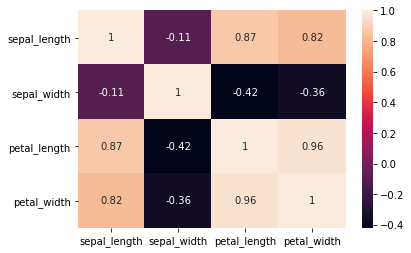

In [9]:
X = data.iloc[:,:-1] # remove the species column
sns.set_palette("RdBu")
correlation = X.corr() #correlation
sns.heatmap(correlation,annot=True)
plt.show()

The purpose of this notebook is to build k-means clustering. Since we can't draw 4-D plots we will reduce the input dimension into two using PCA.

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

pca_out = pca.fit_transform(X)

Now lets form our new data with pca values

In [11]:
data = data[["species"]]
data["c1"] = pca_out[:,0]
data["c2"] = pca_out[:,1]
data = data[["c1","c2","species"]]

A good practice will be trying different number of clusters and checking which number is better using the elbow curve. However since this is just a demo to understan k-means we will use the number of species as our number of clusters. Also we will check how many unique classes we have.

In [12]:
cluster_num = np.unique(data["species"]).shape[0]
print(np.unique(data["species"],return_counts=True))

(array([0, 1, 2]), array([50, 50, 50]))


In [13]:
def plot_classes(X,group): # a function to plot our data
    fig, ax = plt.subplots()

    cdict = {0: 'red', 1: 'blue', 2: 'green'}
    for g in np.unique(group):
        ix = np.where(group == g)[0]
        ax.scatter(X.iloc[:,0][ix], X.iloc[:,1][ix], c = cdict[g], label = g, s = 100)
    plt.grid()

First we will split the data in to X and y (features and labels). We will assign each sample a random label. Then we will find the center point of each cluster. Labels of each sample will be updated depending on how close they are to each center point. We will calculate the Euclidian distance of each sample to each cluster's center point. The sample will be assinged to the nearest cluster.  We will repeat this process untill there is no change in the clusters assigned to each sample. So we will stop when there is no more change.

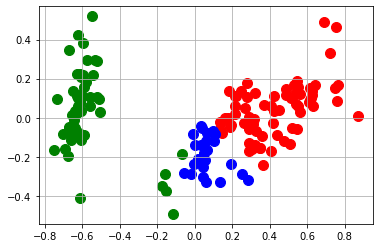

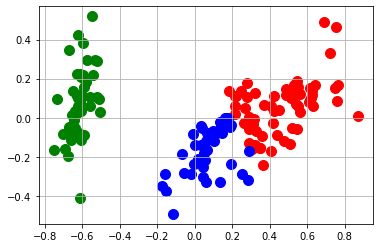

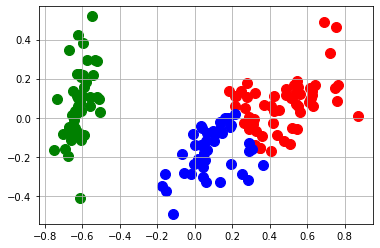

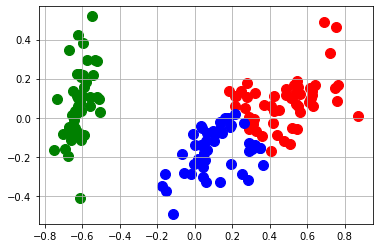

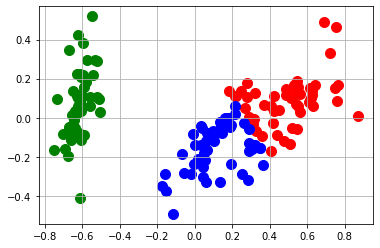

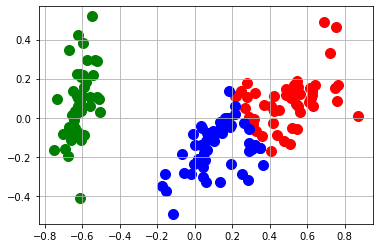

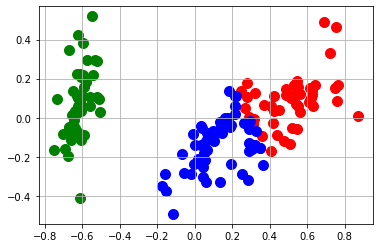

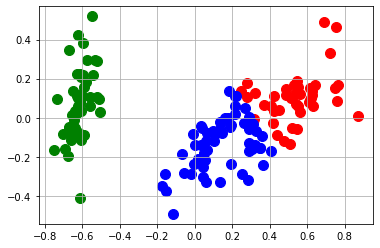

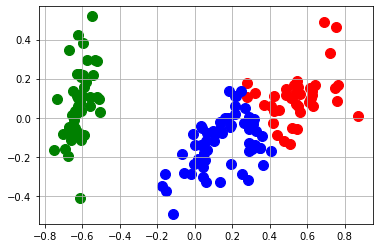

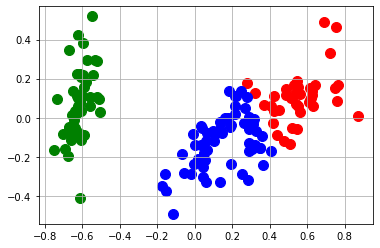

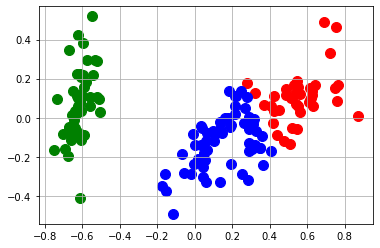

In [14]:
num_point = data.shape[0]
data_cluster = np.random.randint(0,3,num_point)
data_cluster_old = np.zeros(num_point).astype(np.int)

X = data.iloc[:,:-1] # features
y = data.iloc[:,-1] #  label

center_p = np.zeros((3,2)) 

epsilon = 10**-8 # we add a small value to denominator 
plot_steps = True # Make this to false to turn of the plots below (plots at each step)

change = True
while change == True:  

    dist = []
    count = np.zeros(3)
    for k,point in zip(data_cluster,X.values):
        
        center_p[k]+= point
        count[k]+=1
    count+=epsilon
    center_p/=count[:,None]
    
    for k in range(cluster_num):
        dist.append(np.linalg.norm(X.values-center_p[k],axis=1).reshape(-1,1))
    dist = np.concatenate(dist,axis=1)
    data_cluster = np.argmin(dist,axis=1)
    
    change = ~np.all(data_cluster_old == data_cluster) # check if there is a false entry
    data_cluster_old = data_cluster.copy()
    
    if plot_steps:
        plot_classes(X,data_cluster)

Since we know the labels of each sample we can check if our clusters correspond to these labels. We will show each cluster with different colors. We will compare real labels and predicted clusters. But  we should not forget that colors do not have to match. Also clusters doesn't have to correspond with species. Our algorithm may find different pattern forming clusters in a different way.

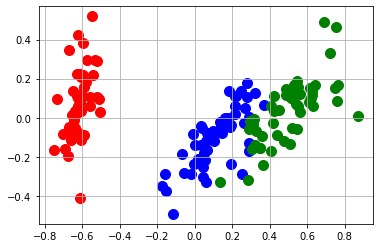

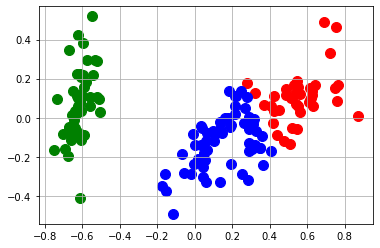

In [15]:
group = y.values
plot_classes(X,group)
group = data_cluster
plot_classes(X,group)

We can see that our clusters more or less corresponds to species. The graph at the top shows species in different colors and the graph at the bottom shows our clusters. Now we will compare our algorithm with sci-kit's k-means.  

In [16]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

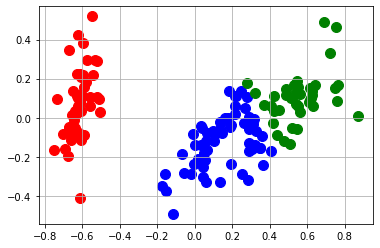

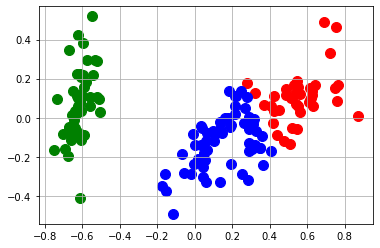

In [17]:
group = kmeans.labels_
plot_classes(X,group)
group = data_cluster
plot_classes(X,group)

We can see that we get similar results with sci-kit's k-mean implemantation